In [5]:
import json #for json files
import sys #used to close json file
import asf_search as asf #ASF search API tool
from hyp3_sdk import HyP3 #ASF API tool for sending INSAR jobs
import csv #creating a .csv
import requests #for checking status of job

#import libraries for file management
import os 
from zipfile import ZipFile 
import shutil

import geopandas as gpd
import pandas as pd
from datetime import datetime
from datetime import timedelta

import psycopg2

In [48]:
conn = psycopg2.connect(host='localhost',database = 'postgres', user='postgres',password = 'postgrespw',port=32768)
tableName = "oyster"

In [8]:
cursor = conn.cursor()
cursor.execute(f"CREATE TABLE IF NOT EXISTS {tableName} (id serial, pair text,site text, insar_name text, reference_date date, vertdisp_path text, coherence_path text)")
conn.commit()
cursor.close()

In [ ]:
directory = os.getcwd()
inputFiles = os.path.join(directory,"geodata")
shpPath = os.path.join(inputFiles,'OB_MCA1.shp')
shp = gpd.GeoDataFrame.from_file('geodata/OB_MCA1.shp')
geometry = str(shp['geometry'][0])
date = str(shp['Date'][0])
JobName = str(shp['Name'][0]).replace(" ","").replace("-","")
print(JobName)
d2 = datetime.strptime(date, '%Y-%m-%d')
end = str(d2 + timedelta(weeks = 52))
start = str(d2 - timedelta(weeks = 52))
print("date = ",date,"\nstart = ",start,"\nend = ",end)

In [6]:
jsonFile = open('geodata/Login.json')
login = json.load(jsonFile)

userName = login['UserName']
if userName == "":
    print("Please input Username")
    sys.exit()
pw = login['Password']
if pw =="":
    print("Please input Password")
    sys.exit()

jsonFile.close()

In [ ]:
#Create an API search based on set parameters
searchResults = asf.search(
    platform = "Sentinel-1",
    beamMode = "IW",
    polarization = "VV+VH",
    intersectsWith = geo, 
    processingLevel= "SLC",
    start = start,
    end = end
)
data = searchResults.geojson()


In [ ]:
#Extracts scenes from job search and creates list of all scene names
def get_scene_name(): 
    count = len(data["features"])                   
    scenes = []
    dates = []
    for x in range(count):
        scene = data["features"][x]["properties"]["sceneName"]
        date = data["features"][x]["properties"]["startTime"]
        scenes.append(scene)
        dates.append(date)
    scenes.reverse()
    dates.reverse()
    df = pd.DataFrame(list(zip(dates, scenes)),columns =['Dates', 'SceneNames'])
    return df
scenesList= get_scene_name() #list with all scene names
len(scenesList)

In [9]:
filtered = scenesList.drop_duplicates()
scenes = list(filtered['SceneNames'])
dates = list(filtered['Dates'])

In [ ]:
def create_jobs(data,date,conn): 
    jobs = [] 
    count = len(data) 
    for i in range(count-1): 
        scene1 = data[i]
        scene2 = data[i+1]
        if date[i+1].endswith('Z'):
            sceneDate = datetime.strptime(date[i+1], '%Y-%m-%dT%H:%M:%S.%fZ').date()
        else:
            sceneDate = datetime.strptime(date[i+1], '%Y-%m-%dT%H:%M:%S.%f').date()
        insar_job = HyP3.prepare_insar_job(scene1, scene2, name = JobName, include_displacement_maps=True,include_dem=True,include_look_vectors=True)
        pair = scene1+','+scene2
        try:
            cursor = conn.cursor()
            cursor.execute(f"SELECT pair, reference_date, vertdisp_path, coherence_path, insar_name FROM {tableName} WHERE pair = %s", (pair,))
            row = cursor.fetchall()
            #if pair is in db
            if row != []:
                #then add new row with same data, but use the JobName as the site
                cursor.execute(f"INSERT INTO {tableName} (pair, reference_date, vertdisp_path, coherence_path, insar_name, site) VALUES (%s, %s, %s, %s, %s ,%s)", (row[0], row[1], row[2], row[3], row[4], JobName))
                conn.commit()
                cursor.close()
                #do not add to jobs list
            else:
                #just do the insert as is
                cursor.execute(f"INSERT INTO {tableName} (pair, site, reference_date) VALUES(%s, %s, %s)", (pair, JobName, sceneDate))
                #add to jobs list
                jobs.append(insar_job)
                conn.commit()
                cursor.close()
        except Exception as e:
            print(e)
            conn = psycopg2.connect(host='localhost',database = 'postgres', user='postgres',password = 'postgrespw',port=32768)
    return jobs 
jobsList = create_jobs(scenes, dates, conn)
print(len(jobsList))

In [ ]:
hyp3 = HyP3(username = userName, password = pw) #authenticate using ASF credentials
batch = hyp3.submit_prepared_jobs(prepared_jobs = jobsList)

#Creates New Folder called "data" where the jobs will be downloaded
output = os.path.join(directory, JobName+'_rawData')
if not os.path.exists(output):
    os.makedirs(output)

#Watch and Download job
if not batch.complete():
    batch = hyp3.watch(batch)
#Downloads files into data folder
batch.download_files(location = output)

In [95]:
output = os.path.join(directory, JobName+'_rawData')
if not os.path.exists(output):
    os.makedirs(output)
#Creates List of zip file names
zipfiles = os.listdir(output)

#Unzips each zip file and deletes the zip
for x in range(len(zipfiles)):
    file = os.path.join(output, zipfiles[x])
    if file.endswith(".zip"):
        with ZipFile(file, 'r') as zipf:
            zipf.extractall(output)
        os.remove(file)

In [96]:

folderList = os.listdir(output)
tifList = []
#Loop through the folders
for x in range(len(folderList)):
    folderName = os.path.join(output, folderList[x])
    fileList = os.listdir(folderName)
    #Loop through files in folder
    for file in fileList:
        #Select file that ends in vert_disp.tif
        if file.endswith(".tif"):
            fileName = os.path.join(folderName, file)
            tifList.append(fileName)
        if file.startswith(folderList[x]+'.txt'):
            fileName = os.path.join(folderName, file)
            f = open(fileName,'r')
            lines = f.readlines()
            scene1 = lines[0].split(' ')
            scene2 = lines[1].split(' ')
         
            pair = scene1[2].replace('\n','')+','+scene2[2].replace('\n','')
            try:
                cursor = conn.cursor()
                cursor.execute(f"SELECT insar_name FROM {tableName} WHERE insar_name = %s AND site = %s",(folderList[x], JobName))
                row = cursor.fetchall()
                if row == []:
                    cursor.execute(f"UPDATE {tableName} SET insar_name = %s WHERE pair = %s AND site = %s",(folderList[x], pair, JobName))
                    conn.commit()
                cursor.close()
            except Exception as e:
                print(e)
                conn = psycopg2.connect(host='localhost',database = 'postgres', user='postgres',password = 'postgrespw',port=32768)

In [97]:
#Libraries for dealing with geotifs
from osgeo import gdal,ogr
import rasterio as rio

In [ ]:
dataset = rio.open(tifList[0])
boundingBox = dataset.bounds
left = boundingBox.left
right = boundingBox.right
top = boundingBox.top
bottom = boundingBox.bottom
print(boundingBox)
for x in range(1,len(tifList)):
    dataset = rio.open(tifList[x])
    boundingBox = dataset.bounds
    if boundingBox.left < left:
        left = boundingBox.left
    if boundingBox.right < right:
        right = boundingBox.right
    if boundingBox.top < top:
        top = boundingBox.top
    if boundingBox.bottom < bottom:
        bottom = boundingBox.bottom
    print(left,bottom,right,top)
minbbox = (left,bottom,right,top)

In [99]:
#Crop the water mask incase it does not have the min bounds
#For loop to crop all the tif files to the min bounds
#all files need to be the same height and width to work with them in numpy
newcrs= str(shp.crs)
opts = gdal.WarpOptions(options=['tr'], outputBounds=minbbox, dstSRS=newcrs, format="GTiff")
for geoTif in tifList:
    dataset = gdal.Open(geoTif)
    filename = geoTif.split('.')[0]+'_crop.tif'
    currentInsar = geoTif.split('\\')[-2]
    newfile = gdal.Warp(filename, dataset, options=opts)
    
    if geoTif.endswith("vert_disp.tif"):
        try: 
            cursor = conn.cursor()
            cursor.execute(f"UPDATE {tableName} SET vertdisp_path = %s WHERE insar_name = %s AND site = %s",(filename, currentInsar, JobName))
            conn.commit()
            cursor.close()
        except Exception as e:
            print('1')
            print(e)
            conn = psycopg2.connect(host='localhost',database = 'postgres', user='postgres',password = 'postgrespw',port=32768)
    if geoTif.endswith("_corr.tif"):
        try: 
            cursor = conn.cursor()
            cursor.execute(f"UPDATE {tableName} SET coherence_path = %s WHERE insar_name = %s AND site = %s",(filename, currentInsar, JobName))
            conn.commit()
            cursor.close()
        except Exception as e:
            print('2')
            print(e)
            conn = psycopg2.connect(host='localhost',database = 'postgres', user='postgres',password = 'postgrespw',port=32768)
  
    dataset = None #close the file

Testing plotting

In [25]:
import numpy as np
import math
import matplotlib.pyplot as plt
import earthpy.plot as ep
import rioxarray as rxr
from rasterio.plot import plotting_extent

In [51]:
date2 = str(d2 + timedelta(weeks = 52))
date1 = str(d2 - timedelta(weeks = 52))
try:
    cursor = conn.cursor()
    cursor.execute(f"SELECT vertdisp_path from {tableName} where reference_date BETWEEN %s AND %s",(date1,date2))
    insars = cursor.fetchall()
    cursor.close()
except:
    conn = psycopg2.connect(host='localhost',database = 'postgres', user='postgres',password = 'postgrespw',port=32768)

2018-09-29 00:00:00
2016-10-01 00:00:00


In [ ]:
insar1 = gdal.Open(insars[0][0])
print(insar1)
geotrans=insar1.GetGeoTransform() #gets metadata drom the opened tif
proj=insar1.GetProjection()
sum = insar1.ReadAsArray()
height=sum.shape[0]
width=sum.shape[1]
insar1 = None
for x in range(1,len(insars)-1):
    img = gdal.Open(insars[x][0]).ReadAsArray()
    sum = np.add(sum,img)
    img=None

In [86]:
dst_filename = os.path.join(directory,"OBpre6wkSum2.tif")
driver = gdal.GetDriverByName('GTiff')
dataset1 = driver.Create(dst_filename,width,height,1, gdal.GDT_Float32)
dataset1.GetRasterBand(1).WriteArray(sum)
#Applying the metadata to the newly created tif:
dataset1.SetGeoTransform(geotrans)
dataset1.SetProjection(proj)
dataset1.FlushCache()
dataset1=None #Close the file

In [105]:
# Create a buffered polygon layer from your plot location points
site = gpd.GeoDataFrame.from_file('geodata/BB_Merge.shp')
sumData = rxr.open_rasterio(dst_filename)

newCRS = site.crs
sumData.rio.write_crs(newCRS,inplace=True)

In [ ]:
print(site['geometry'])

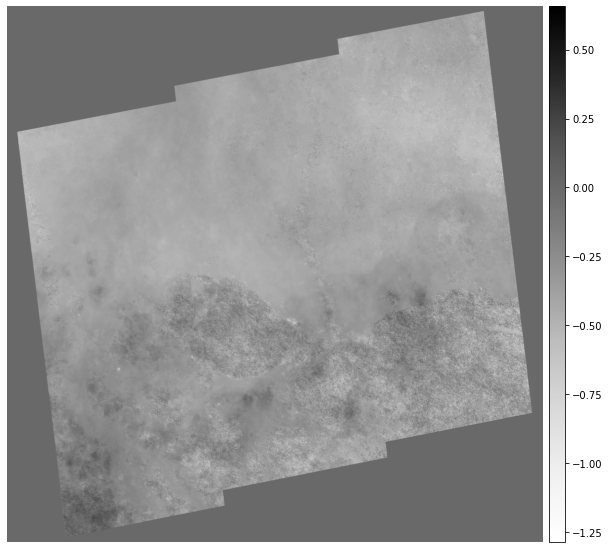

In [103]:
sumData = rxr.open_rasterio(dst_filename)

fig, ax = plt.subplots(figsize=(10, 10))

ep.plot_bands(sumData,extent = extent,cmap='Greys',ax=ax)
#shp.plot(ax=ax,color='purple')
ax.set_axis_off()

plt.show()

Mintypy stuff below

In [ ]:
import subprocess
from mintpy.cli import tsview
from mintpy.cli import plot_transection
import ipympl

In [ ]:
runMinty = subprocess.run(["smallbaselineApp.py","mintpyConfigFile.txt"])
getVelocity = subprocess.run(["smallbaselineApp.py", "--dostep", "velocity", "mintpyConfigFile.txt"])

In [ ]:
%matplotlib widget
ts_file = os.path.expanduser('timeseries.h5')
cmd = f'{ts_file} --yx 220 300 --figsize 9 3'
tsview.main(cmd.split())

In [ ]:
%matplotlib widget
ts_file = os.path.expanduser('timeseries.h5')
cmd = f'{ts_file} --yx 220 300 --figsize 9 3'
tsview.main(cmd.split())

In [ ]:
vel_file = os.path.expanduser('avgPhaseVelocity.h5')
cmd = f'{vel_file} --figsize 10 5'
plot_transection.main(cmd.split())

In [12]:
import h5py
import pandas as pd
import rioxarray
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import plotting_extent
import rioxarray as rxr
import rasterstats as rs
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

In [ ]:
# Create a buffered polygon layer from your plot location points
shpBuff = shp.copy()

# Buffer each point using a 20 meter circle radius 
# and replace the point geometry with the new buffered geometry
shpBuff["geometry"] = shp.geometry.buffer(0.01)
shpBuff.geometry
shpBuff = shpBuff.rio.reproject(crs)
inputFiles = os.path.join(directory,"geodata")
saveBuffer = os.path.join(inputFiles,JobName+"buffed.shp")
shpBuff.to_file(saveBuffer)


In [68]:
openRaster = rxr.open_rasterio(insars[0][0])
crs = str(openRaster.rio.crs)
epsgnum=crs.split(':')[1]
print(crs)
print(epsgnum)
shpcopy = shp.copy()
shpreproj = shpcopy.set_crs(epsg=epsgnum,inplace=True,allow_override=True)
reprojPath = os.path.join(inputFiles,'shpreproj.shp')
shpreproj.to_file(reprojPath)
openRaster=None

EPSG:32615
32615


In [17]:
import earthpy.spatial as es

In [ ]:
pathInSAR =[]
for x in range(len(insars)):
    pathInSAR.append(insars[x][0])
print(pathInSAR)

save = os.path.join(directory,"multiBand.tif")

vertStack, vertMeta = es.stack(pathInSAR, save)

In [76]:
test123 = rxr.open_rasterio(insars[0][0])
testAffine = test123.rio.transform()
print(type(testAffine))
testshp =gpd.GeoDataFrame.from_file(reprojPath)



<class 'affine.Affine'>
EPSG:32615
epsg:32615


In [89]:
for x in range(len(insars)):
    pathInSAR.append(insars[x][0])

<class 'pyproj.crs.crs.CRS'>


In [103]:
folderList = os.listdir(output)
reprojList = []
#Loop through the folders
for x in range(len(folderList)):
    folderName = os.path.join(output, folderList[x])
    fileList = os.listdir(folderName)
    #Loop through files in folder
    for file in fileList:
        #Select file that ends in vert_disp.tif
        if file.endswith("vert_disp_crop_crop.tif"):
            fileName = os.path.join(folderName, file)
            reprojList.append(fileName)

In [104]:
print(reprojList)

['c:\\Users\\Melay\\Documents\\CoastalEnrichment\\Code\\OBMCA1_rawData\\S1AA_20161016T001816_20161028T001816_VVP012_INT80_G_ueF_E596\\S1AA_20161016T001816_20161028T001816_VVP012_INT80_G_ueF_E596_vert_disp_crop_crop.tif', 'c:\\Users\\Melay\\Documents\\CoastalEnrichment\\Code\\OBMCA1_rawData\\S1AA_20161028T001816_20161109T001816_VVP012_INT80_G_ueF_9A55\\S1AA_20161028T001816_20161109T001816_VVP012_INT80_G_ueF_9A55_vert_disp_crop_crop.tif', 'c:\\Users\\Melay\\Documents\\CoastalEnrichment\\Code\\OBMCA1_rawData\\S1AA_20161109T001816_20161121T001815_VVP012_INT80_G_ueF_2505\\S1AA_20161109T001816_20161121T001815_VVP012_INT80_G_ueF_2505_vert_disp_crop_crop.tif', 'c:\\Users\\Melay\\Documents\\CoastalEnrichment\\Code\\OBMCA1_rawData\\S1AA_20161121T001815_20161203T001815_VVP012_INT80_G_ueF_F7CD\\S1AA_20161121T001815_20161203T001815_VVP012_INT80_G_ueF_F7CD_vert_disp_crop_crop.tif', 'c:\\Users\\Melay\\Documents\\CoastalEnrichment\\Code\\OBMCA1_rawData\\S1AA_20161203T001815_20161215T001815_VVP012_INT8

In [ ]:
# Extract zonal stats
timeseriesStats = gpd.GeoDataFrame(columns=['count','min','mean','max','median'])

for x in range(len(reprojList)):
    openRaster = rxr.open_rasterio(reprojList[x])
    affine=openRaster.rio.transform()
    currentStats = rs.zonal_stats(shpPath,
                                    reprojList[x],
                                    #nodata = -999,
                                    affine=affine,
                                    #geojson_out=True,
                                    copy_properties=True,
                                    all_touched=True,
                                    stats="count min mean max median")
    print(currentStats)
    properties=currentStats[0]
    stats = properties['count'], properties['min'], properties['mean'], properties['max'],properties['median']
    print(stats)

    timeseriesStats.loc[len(timeseriesStats)] = stats
    openRaster=None
    affine=None

#print(timeseriesStats)


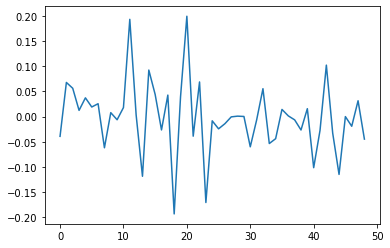

In [110]:
fig = plt.figure()
ax = plt.axes()
ax.plot(timeseriesStats['mean'])

In [ ]:
from osgeo import gdal
inputFiles = os.path.join(directory,"geodata")
shapeFile = os.path.join(inputFiles, 'SC-Unit1D.shp')

epsg = "EPSG:26915"
sumts = os.path.join(directory, "SUM.tif")
input_raster = gdal.Open(sumts)
#input_shp = gdal.Open(shapeFile)
opts = gdal.WarpOptions(options=['tr'], dstSRS=epsg, format="GTiff")
gdal.Warp('Reproject.tif', input_raster, options=opts)
#gdal.Warp('Reproject.shp', srcDSOrSrcDSTab=shapeFile, dstSRS=epsg, format="shp")
input_raster = None
#input_shp = None

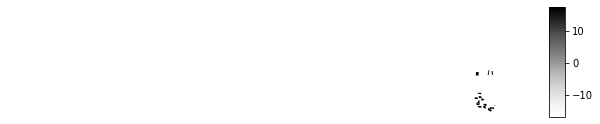

In [81]:
from matplotlib import pyplot
import earthpy as et
import earthpy.plot as ep
src=None
src = rxr.open_rasterio(reprojectedtif)
polygon = gpd.read_file(crschange)
fig, ax = plt.subplots(figsize=(10, 10))
ep.plot_bands(src,
                extent=plotting_extent(src,src.rio.transform()),
                scale=False,
                cmap='Greys',
                ax=ax)
polygon.plot(ax=ax,color='black')
ax.set_axis_off()
plt.show()